# How to optimize transpilation

In the tutorials, the subexperiments were generated and then each one was transpiled independently.

It is possible instead to optimize the workflow by performing the bulk of transpilation up front, followed by some minor passes over the generated circuits (e.g., to ensure they uses the basis gates available on the hardware, or to perform local optimizations).  This guide provides one way to do this.

NOTE: The steps in this guide only work if the circuit is _separated_ by the cut gates.  If you are performing circuit cutting to reduce a circuit's depth, then the following steps will not work.  See issue [#576](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/issues/576) for details.

### Specify a backend

You can provide either a fake backend or a hardware backend from Qiskit Runtime.

In [1]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

### Create a circuit and observable; partition the problem

See the first tutorial for details on these steps.

In [2]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from circuit_knitting.cutting import partition_problem

qc = EfficientSU2(4, entanglement="linear", reps=2).decompose()
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

observable = SparsePauliOp(["ZZII", "IXIX"])

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

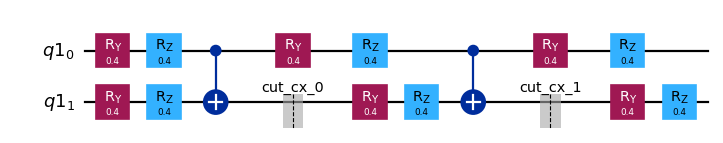

In [3]:
subcircuits["A"].draw("mpl", scale=0.8)

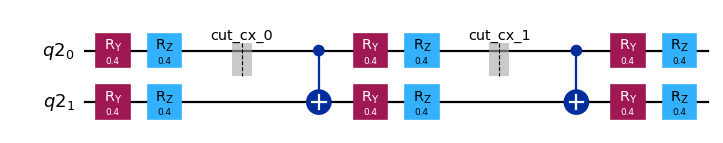

In [4]:
subcircuits["B"].draw("mpl", scale=0.8)

### Transpile the subcircuits

Create a fake backend, and modify the target gate set so it thinks a `SingleQubitQPDGate` is allowed.

In [ ]:
from copy import deepcopy
from qiskit.circuit.library import CXGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from circuit_knitting.cutting.qpd import SingleQubitQPDGate, QPDBasis

# Create a fake backend, and modify the target gate set so it thinks a
# SingleQubitQPDGate is allowed.
target = deepcopy(backend.target)
sample_qpd_instruction = SingleQubitQPDGate(QPDBasis.from_instruction(CXGate()), 1)
target.add_instruction(
    sample_qpd_instruction,
    {(i,): None for i in range(target.num_qubits)},
)
pass_manager = generate_preset_pass_manager(3, target=target)

Run each subcircuit through the pass manager.

In [ ]:
transpiled_subcircuits = {
    label: pass_manager.run(subcircuits[label])
    for label, circuit in subcircuits.items()
}

Notice that the `SingleQubitQPDGate`s pass through untouched.

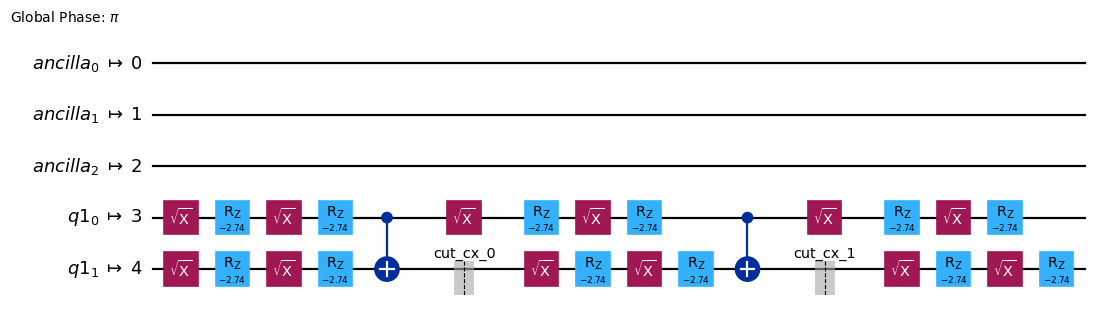

In [6]:
transpiled_subcircuits["A"].draw("mpl", scale=0.8)

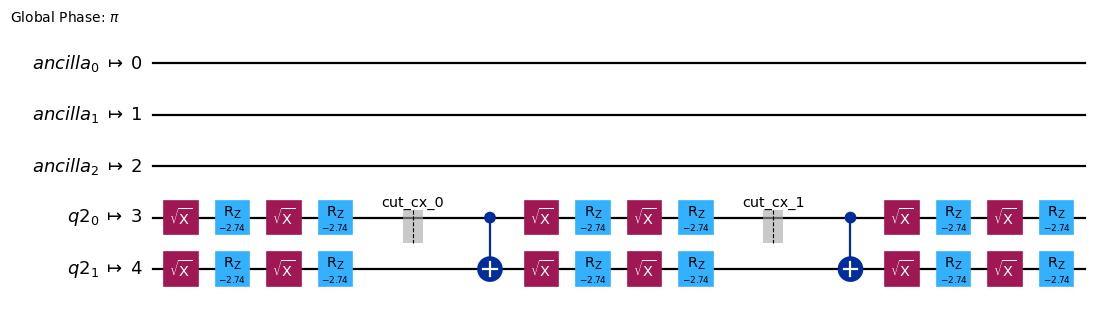

In [7]:
transpiled_subcircuits["B"].draw("mpl", scale=0.8)

### Transform the subobservables

The subobservables need to have their qubits mapped to the physical qubits in the transpiled subcircuits.

In [8]:
transpiled_subobservables = {
    label: SparsePauliOp(subobservables[label])
    .apply_layout(transpiled_subcircuits[label].layout)
    .paulis
    for label, circuit in subobservables.items()
}

### Generate subexperiments

In [9]:
import numpy as np
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=transpiled_subcircuits,
    observables=transpiled_subobservables,
    num_samples=np.inf,
)

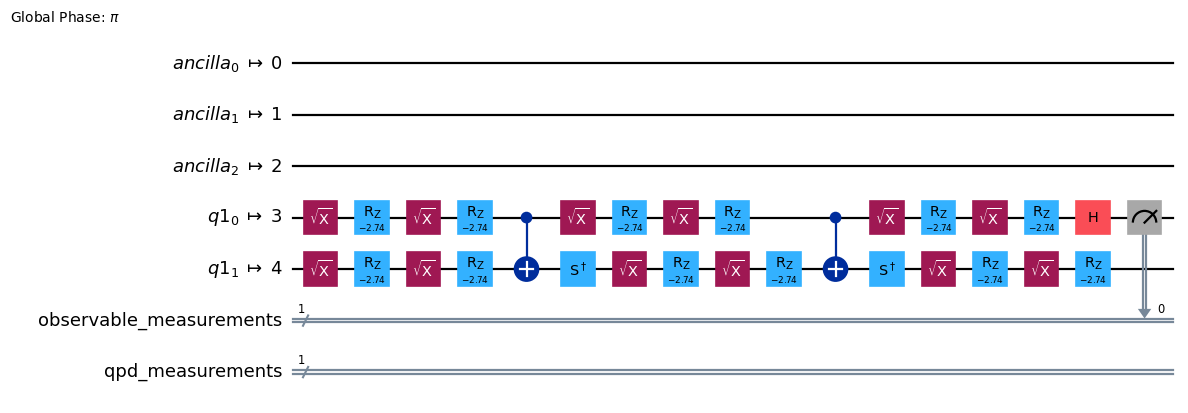

In [10]:
subexperiments["A"][0].draw("mpl", scale=0.8)

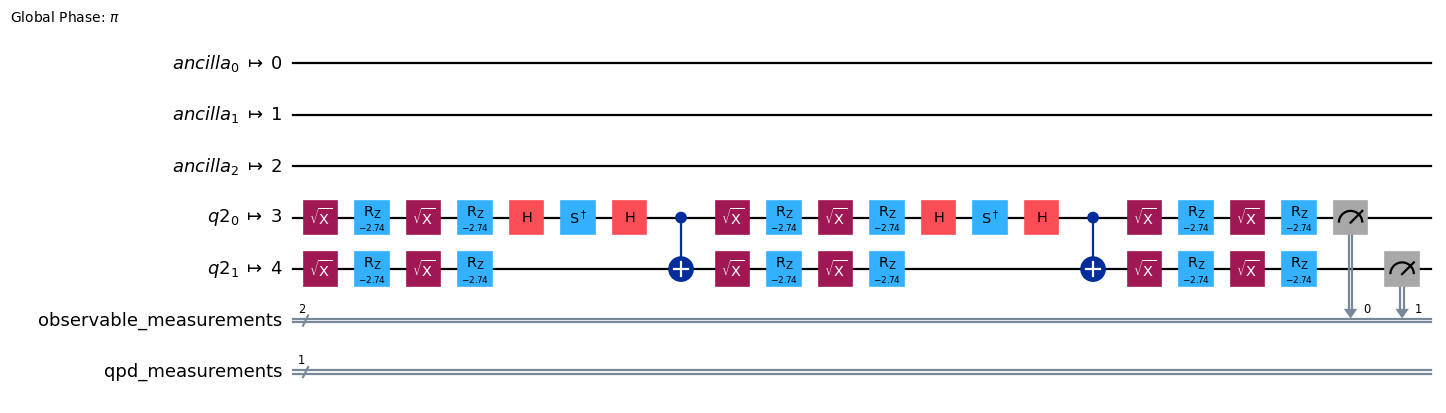

In [11]:
subexperiments["B"][0].draw("mpl", scale=0.8)

### Transform to target basis gate set

Not yet possible, but in progress in pull request [#517](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/pull/517).